In [1]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import time
import glob
from lxml.html import parse
from sphfile import SPHFile
import pydub
import audiosegment
import pandas as pd
from collections import Counter
from bs4 import BeautifulSoup
import sys
import os
from tqdm.notebook import tqdm
from itertools import permutations
import torch
import torch.nn.functional as F
from librosa.core import resample
EPS = 1e-8

from modules import *

import pathlib
def create_dir(filename):
    pathlib.Path('/'.join(filename.split('/')[:-1])).mkdir(parents=True, exist_ok=True)
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)
old_sr = 8000
new_sr = 8000
dropout = 0.3
half = False
root = '../'
device = 0
devices = [0, 1, 2, 3]

In [2]:
def make_spectrogram(segment):
    segment = segment[50:-50] # make size 200
    S = np.abs(librosa.stft(segment, n_fft = 255, hop_length = 125)) # 32 ms window, 16 ms hop
    return S

def find_max2(tensor):
    array = tensor.cpu().detach().numpy()
    max2 = []
    for row in array:
        max2.append(np.argsort(row)[::-1][:2])
    return np.array(max2)

def compute_corrects(tensor1, tensor2):
    max_1, max_2 = find_max2(tensor1), find_max2(tensor2)
    batch_size = max_1.shape[0]
    batch_corrects = 0
    for i in range(batch_size):
        if Counter(max_1[i])==Counter(max_2[i]):
            batch_corrects+=1
    return batch_corrects

def compute_correct(tensor1, tensor2):
    tensor1, tensor2 = tensor1.cpu().detach().numpy(), tensor2.cpu().detach().numpy()
    batch_size = tensor1.shape[0]
    batch_corrects = 0
    for i in range(batch_size):
        if np.argmax(tensor1[i]) == np.argmax(tensor2[i]):
            batch_corrects += 1
    return batch_corrects

def cross_entropy(input, target, size_average=True):
    if size_average:
        return torch.mean(torch.sum(-target * torch.log(input), dim=1))
    else:
        return torch.sum(torch.sum(-target * torch.log(input), dim=1))

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


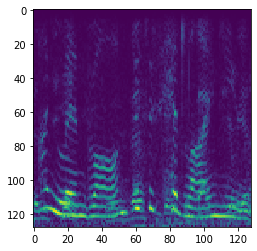

In [3]:
class OverlayDataSet(torch.utils.data.Dataset):
    def __init__(self, csv):
        super().__init__()
        self.segments = pd.read_csv(root+csv)
        self.speakers = list(set(self.segments['speaker']))
        self.speakers.sort()
        self.spkr2idx = {spkr:i for i, spkr in enumerate(self.speakers)}

    def __len__(self):
        return len(self.segments)
    def __getitem__(self, idx):
        seg1 = self.segments.iloc[idx]
        seg2 = self.segments.iloc[np.random.randint(len(self.segments))]
        while(seg1['speaker']==seg2['speaker']):
            seg2 = self.segments.iloc[np.random.randint(len(self.segments))]

        sig1 = np.load(root+seg1['segfile'])
        sig2 = np.load(root+seg2['segfile'])

        spec1 = np.log(1+make_spectrogram(sig1))[None, ...]
        spec2 = np.log(1+make_spectrogram(sig2))[None, ...]
        source = np.log(1+make_spectrogram(sig1+sig2))[None, ...]
        
        out_vec1 = np.zeros(len(self.speakers)) # maybe try PIT training too
        out_vec2 = np.zeros(len(self.speakers)) # maybe try PIT training too
        out_vec1[self.spkr2idx[seg1['speaker']]] = 1
        out_vec2[self.spkr2idx[seg2['speaker']]] = 1

        return source, np.concatenate((spec1, spec2), axis = 0), out_vec1, out_vec2


#mean, std = compute_mean_std('overlay-train.csv')


trainset = OverlayDataSet('train-segments.csv')
valset = OverlayDataSet('val-segments.csv')
testset = OverlayDataSet('test-segments.csv')
mixture, sources, target1, target2 = trainset[5]
plt.imshow(mixture[0][::-1])
print(target1, target2)

## Maybe try skipping mask directly to last layer

In [11]:
extractor = nn.Sequential(ResidualBlock(1, 128),
                          AttentionModule_stage1(128, 64),
                          ResDilationBlock(64, 64), # largest dilation is 32
                          ResDilationBlock(64, 64), # largest dilation is 32
                          ResDilationBlock(64, 128), # largest dilation is 32
                          AttentionModule_stage1(128, 2),
                          nn.ReLU()
                         ).cuda(device)
checkpoint = torch.load('models/joint-extractor.pth')
extractor.load_state_dict(checkpoint['model_state_dict'])
optimizer1 = torch.optim.Adam(extractor.parameters(), lr = 0.0001)
extractor = torch.nn.DataParallel(extractor, device_ids = devices)

In [13]:
len_slice = 20
shift = 1
n_hidden = 800
n_layers = 3
num_heads = 4
dropout = 0.3
class IDnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size = 128, hidden_size = 200, num_layers = n_layers, dropout = dropout, bidirectional = True)# receptive field 32 frames
        #self.mha =  nn.MultiheadAttention(n_hidden*2, num_heads = num_heads, dropout = dropout, bias=True) # L * batch * 64
        self.fc1 = nn.Linear(len_slice*200*2, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, 20)
        self.softmax = nn.Softmax(-1)
        self.clamp = Lambda(lambda x: x.clamp(min = 1e-8))
        self.use_all_chunks = True
        self.act = nn.ReLU()
        
    def forward(self, X):
        # [batch_size, 1, F, L]
        X = X.squeeze(dim = 1).permute(2, 0, 1) # [L, batch_size, F]
        X = self.chop_chunk(X)
        out = self.estimate(X)
        return out
    
    def predict_chunk(self, chunk):
        # chunk size : [len_slice, batch_size, F]
        X = chunk
        X, _ = self.lstm(X)
        #X = self.mha(X)
        X = X.permute(1, 0, 2).contiguous().view(X.shape[1], -1) # [batch_size, n_hidden*len_slice]
        X = self.act(self.fc1(X))
        X = self.act(self.fc2(X))
        X = self.fc3(X)
        X = self.softmax(X)
        X = self.clamp(X)
        return X
    
    def chop_chunk(self, spec):
        # [L, batch_size, F]
        n_frames, batch_size, n_feats = spec.shape
        N_slices=(n_frames-len_slice)//shift
        chunks = []
        for i in range(N_slices):
            chunks.append(spec[i*shift:i*shift+len_slice]) # list of N_fr elements, each (batch_size*wlen)
        return chunks
    
    def estimate(self, chunks):
        out_vecs = []
        if not self.use_all_chunks:
            chunks = chunks[::10]
        for chunk in chunks:
            #self.lstm.flatten_parameters()
            out_vecs.append(self.predict_chunk(chunk)) # list of N_fr elements, each (batch_size*N_spkr), softmaxed
        out_tensor = torch.stack(out_vecs, dim = 1) # batch_size*N_fr*N_spkr
        out_tensor = out_tensor.mean(dim = 1) # batch_size*N_spkr
        return out_tensor 
    
discriminator = IDnet().cuda(device)
discriminator.load_state_dict(torch.load('models/joint-discriminator.pth')['model_state_dict'])
optimizer2 = torch.optim.Adam(discriminator.parameters(), lr = 0.0001)
bestacc = torch.load('models/best-joint-discriminator.pth')['bestacc']
#discriminator = torch.nn.DataParallel(discriminator, device_ids = devices)
bestacc

0.9188007495315428

In [ ]:
batch_size = 32
alpha = 2
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True, num_workers = 16)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, pin_memory = True, num_workers = 16)

criterion = cross_entropy

for epoch in range(64):
    extractor.train()
    discriminator.train()
    discriminator.use_all_chunks = False
    running_loss = 0.0
    running_cls_loss = 0.0
    running_accuracy = 0.0
    for batch_idx, (mixture, sources, target1, target2) in enumerate(tqdm(trainloader)):
        optimizer1.zero_grad()
        #optimizer2.zero_grad()

        mixture = mixture.float().cuda(device)
        sources = sources.float().cuda(device)
        target1 = target1.float().cuda(device)
        target2 = target2.float().cuda(device)

        sources_reconstructed = extractor(mixture)
        loss1, min_mse, _, reorder_sources = cal_loss(sources, sources_reconstructed)
        pred1, pred2 = discriminator(reorder_sources[:, 0]), discriminator(reorder_sources[:, 1])
        pred = torch.stack([pred1, pred2], dim=0)
        pred, _= torch.max(pred, dim=0)
        #loss2 = cross_entropy(pred1, target1) + cross_entropy(pred2, target2)
        loss2 = cross_entropy(pred, target1+target2)
        loss = loss1*5+loss2
        loss.backward()
        torch.nn.utils.clip_grad_norm_(extractor.parameters(), 0.5)
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 0.5)
        optimizer1.step()
        optimizer2.step()


        running_loss += loss1.item()
        running_cls_loss += loss2.item()
        running_accuracy += compute_corrects(pred, target1+target2)/batch_size

        if batch_idx % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] reconstruction loss: %.3f cls loss: %.3f accuracy: %.3f' % 
                  (epoch + 1, batch_idx + 1, running_loss / 200, running_cls_loss/200, running_accuracy / 200))
            torch.save({
            'model_state_dict': extractor.module.state_dict(),
            'optimizer_state_dict': optimizer1.state_dict(),
            'loss': running_loss,
            }, 'models/joint-extractor.pth')
            torch.save({
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': optimizer2.state_dict(),
            'acc': running_accuracy
            }, 'models/joint-discriminator.pth')
            running_loss = 0.0
            running_cls_loss = 0.0
            running_accuracy = 0.0

    extractor.eval()
    discriminator.eval()
    discriminator.use_all_chunks = True
    running_loss = 0.0
    running_accuracy = 0.0
    with torch.no_grad():
        for batch_idx, (mixture, sources, target1, target2) in enumerate(tqdm(valloader)):
            mixture = mixture.float().cuda(device)
            sources = sources.float().cuda(device)
            target1 = target1.float().cuda(device)
            target2 = target2.float().cuda(device)

            sources_reconstructed = extractor(mixture)
            loss1, min_mse, _, reorder_sources = cal_loss(sources, sources_reconstructed)
            pred1, pred2 = discriminator(sources_reconstructed[:, 0]), discriminator(sources_reconstructed[:, 1])
            pred = torch.stack([pred1, pred2], dim=0)
            pred, _= torch.max(pred, dim=0)


            running_loss += loss1.item()*mixture.shape[0]
            running_accuracy += compute_corrects(pred, target1+target2)

        print('[%d, %5d] reconstruction loss: %.3f accuracy: %.3f' % 
              (epoch + 1, batch_idx + 1, running_loss / len(valset), running_accuracy / len(valset)))

        
        if running_accuracy / len(valset) > bestacc:
            bestacc = running_accuracy / len(valset)
            torch.save({
            'model_state_dict': extractor.module.state_dict(),
            'optimizer_state_dict': optimizer1.state_dict(),
            'loss': running_loss,
            }, 'models/best-joint-extractor.pth')
            torch.save({
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': optimizer2.state_dict(),
            'bestacc': running_accuracy / len(valset)
            }, 'models/best-joint-discriminator.pth')
            running_loss = 0.0
            running_cls_loss = 0.0
            running_accuracy = 0.0

[1,   200] reconstruction loss: 0.018 cls loss: 0.391 accuracy: 0.942
[1,   400] reconstruction loss: 0.018 cls loss: 0.409 accuracy: 0.934
[1,   600] reconstruction loss: 0.018 cls loss: 0.385 accuracy: 0.937
[1,   800] reconstruction loss: 0.017 cls loss: 0.369 accuracy: 0.945
[1,  1000] reconstruction loss: 0.017 cls loss: 0.373 accuracy: 0.936
[1,  1200] reconstruction loss: 0.018 cls loss: 0.422 accuracy: 0.936




[1,   151] reconstruction loss: 0.017 accuracy: 0.921


[2,   200] reconstruction loss: 0.018 cls loss: 0.379 accuracy: 0.941
[2,   400] reconstruction loss: 0.018 cls loss: 0.413 accuracy: 0.932
[2,   600] reconstruction loss: 0.018 cls loss: 0.384 accuracy: 0.935
[2,   800] reconstruction loss: 0.018 cls loss: 0.374 accuracy: 0.944
[2,  1000] reconstruction loss: 0.017 cls loss: 0.362 accuracy: 0.943
[2,  1200] reconstruction loss: 0.018 cls loss: 0.411 accuracy: 0.938




[2,   151] reconstruction loss: 0.017 accuracy: 0.925
